In [14]:
import matplotlib.pyplot as plt
import numpy as np
from pypokerengine.players import BasePokerPlayer
from pypokerengine.api.game import setup_config, start_poker
from pypokerengine.utils.card_utils import gen_cards, estimate_hole_card_win_rate
import inspect
from pypokerengine.engine.hand_evaluator import HandEvaluator
from pypokerengine.engine.card import Card


In [5]:
NB_SIMULATION = 100
class HonestPlayer(BasePokerPlayer):
    def __init__(self, raise_wr = 0.6, call_wr = 0.3):
        super().__init__() 
        self.raise_wr = raise_wr
        self.call_wr = call_wr
        
    def declare_action(self, valid_actions, hole_card, round_state):
        curframe = inspect.currentframe()
        calframe = inspect.getouterframes(curframe, 2)
        community_card = round_state['community_card']
        win_rate = estimate_hole_card_win_rate(
                nb_simulation=NB_SIMULATION,
                nb_player=self.nb_player,
                hole_card=gen_cards(hole_card),
                community_card=gen_cards(community_card)
                )
        if win_rate >= self.raise_wr:
            #print('Raising)', win_rate)
            action = valid_actions[2]  # fetch bet action info
            valid_amounts = action['amount']
            raise_amount =  (valid_amounts['max'] - valid_amounts['min'])/ 5.0 + valid_amounts['min']
            return valid_actions[2]['action'], raise_amount
        elif win_rate >= self.call_wr:
            #print('Calling')
            action = valid_actions[1]  # fetch CALL action info
        else:
            call_amount = valid_actions[1]['amount']
            if(call_amount == 0):
                #print('Calling')
                return valid_actions[1]['action'], valid_actions[1]['amount']
            #print('Folding')
            action = valid_actions[0]  # fetch FOLD action info
        return action['action'], action['amount']

    def receive_game_start_message(self, game_info):
        self.nb_player = game_info['player_num']

    def receive_round_start_message(self, round_count, hole_card, seats):
        pass

    def receive_street_start_message(self, street, round_state):
        pass

    def receive_game_update_message(self, action, round_state):
        pass

    def receive_round_result_message(self, winners, hand_info, round_state):
        pass

In [67]:
def iterate_actions(hand_data):
    """Iterates over all actions in the 'action_histories' of a given hand.
    
    Args:
    hand_data: A dictionary representing a hand of poker.
    
    Yields:
    A tuple containing the action type, the amount, the player's UUID, and the round.
    """
    if(hand_data):
        for round_name, actions in hand_data['action_histories'].items():
            for action in actions:
                yield (action['action'], action.get('amount'), action['uuid'], round_name)
    
        

# for action_type, amount, player_uuid, round_name in iterate_actions(round_state_save):
#   print(f"Action: {action_type}, Amount: {amount}, Player: {player_uuid}, Round: {round_name}")


round_state_save = None
hand_info_save = None
class BijPlayer(BasePokerPlayer):
    def __init__(self):
        super().__init__() 
        self.player_histories = {}
        self.player_tendencies = {}
        self.hand_evaluator = HandEvaluator()
        self.INVERTED_HAND_STRENGTH_MAP = {value: key for key, value in self.hand_evaluator.HAND_STRENGTH_MAP.items()}

        self.player_showdown_scores = {}
        self.player_showdown_score_avgs = {}

        
    def declare_action(self, valid_actions, hole_card, round_state):
       return valid_actions[1]['action'], valid_actions[1]['amount']

    def receive_game_start_message(self, game_info):
        self.nb_player = game_info['player_num']

    def receive_round_start_message(self, round_count, hole_card, seats):
        pass

    def receive_street_start_message(self, street, round_state):
        pass

    def receive_game_update_message(self, action, round_state):
        pass

    def receive_round_result_message(self, winners, hand_info, round_state):
        #print('winner: ', winners)
        print('hand_info: ', hand_info)
        print('round_state: ', round_state)
        for action_type, amount, player_uuid, round_name in iterate_actions(round_state):
            #print(f"Action: {action_type}, Amount: {amount}, Player: {player_uuid}, Round: {round_name}")
            try:
                self.player_histories[player_uuid] += [action_type]
            except KeyError:
                self.player_histories[player_uuid] = [action_type]
        #print(self.player_histories)

        # Calculate fold percentage of player
        for player in self.player_histories:
            count_fold = self.player_histories[player].count('FOLD')
            count_call = self.player_histories[player].count('CALL')
            count_raise = self.player_histories[player].count('RAISE')
            count_opportunities = count_fold+count_call+count_raise
            #print(player, count_fold, count_call, count_raise, count_call / count_opportunities)
            
            self.player_tendencies[player] = {'rate_fold': count_fold / count_opportunities,
                                              'rate_call': count_call / count_opportunities,
                                              'rate_raise': count_raise / count_opportunities,
                                              'count_opportunities': count_opportunities}
        # Calculate the hand showdown strengths for the players
        global round_state_save
        round_state_save = round_state
        global hand_info_save
        hand_info_save = hand_info
        #round_state:  {'street': 'showdown',
        
        
        # Now we calculate the average showdown strength of each player
        for player in hand_info:
            player_uuid = player['uuid']
            ri = player['hand']
    
            score = make_score(INVERTED_HAND_STRENGTH_MAP[ri['hand']['strength']], ri['hand']['high'], ri['hand']['low'], ri['hole']['high'], ri['hole']['low'])
            try:
                self.player_showdown_scores[player_uuid] += [score]
            except KeyError:
                self.player_showdown_scores[player_uuid] = [score]
            self.player_showdown_score_avgs[player_uuid] = np.mean(self.player_showdown_scores[player_uuid])

        print('\n: ', self.uuid)
        for player in self.player_tendencies:
            print(player)
            print(self.player_tendencies.get(player))
            print(self.player_showdown_score_avgs.get(player))
            

In [58]:
if(round_state_save['street'] == 'showdown'):
    community_cards = round_state_save['community_card']
    
    pass

for player in hand_info_save:
    ri = player['hand']
    print(ri)
    print(player['uuid'], make_score(INVERTED_HAND_STRENGTH_MAP[ri['hand']['strength']], ri['hand']['high'], ri['hand']['low'], ri['hole']['high'], ri['hole']['low']))
    
hand_info_save

{'hand': {'strength': 'ONEPAIR', 'high': 14, 'low': 0}, 'hole': {'high': 14, 'low': 9}}
rvaofiiwxinubrmozvwwot 123113
{'hand': {'strength': 'ONEPAIR', 'high': 2, 'low': 0}, 'hole': {'high': 4, 'low': 2}}
qldoxuexlruzjddeoraino 73794


[{'uuid': 'rvaofiiwxinubrmozvwwot',
  'hand': {'hand': {'strength': 'ONEPAIR', 'high': 14, 'low': 0},
   'hole': {'high': 14, 'low': 9}}},
 {'uuid': 'qldoxuexlruzjddeoraino',
  'hand': {'hand': {'strength': 'ONEPAIR', 'high': 2, 'low': 0},
   'hole': {'high': 4, 'low': 2}}}]

In [68]:
my_hand_evaluator = HandEvaluator()
INVERTED_HAND_STRENGTH_MAP = {value: key for key, value in my_hand_evaluator.HAND_STRENGTH_MAP.items()}

hole_cards = [Card('D', 7), Card('H', 13)]
community_cards = [Card('D', 2), Card('D', 3), Card('D', 4), Card('D', 5)]
score = my_hand_evaluator.eval_hand(hole_cards, community_cards)
print(score)
ri = my_hand_evaluator.gen_hand_rank_info(hole_cards, community_cards)
print(ri)
def make_score(hand_strength, hand_high, hand_low, hole_high, hole_low):
    return (hand_strength << 8) | (hand_high << 12) | (hand_low << 8) | (hole_high << 4) | hole_low
print(make_score(INVERTED_HAND_STRENGTH_MAP[ri['hand']['strength']], ri['hand']['high'], ri['hand']['low'], ri['hole']['high'], ri['hole']['low']))

1077463
{'hand': {'strength': 'FLASH', 'high': 7, 'low': 0}, 'hole': {'high': 13, 'low': 7}}
1077463


In [69]:
results_dict = {'p1': [], 'p2': [], 'p3': [], 'p4': []}
initial_stack = 1000
for i in range(1):
    config = setup_config(max_round=10, initial_stack=initial_stack, small_blind_amount=5)
    config.register_player(name="p1", algorithm=HonestPlayer())
    config.register_player(name="p2", algorithm=HonestPlayer(raise_wr = 0.9, call_wr=0.7))
    config.register_player(name="p3", algorithm=HonestPlayer(raise_wr = 0.3, call_wr=0.1))
    config.register_player(name="p4", algorithm=BijPlayer())
    game_result = start_poker(config, verbose=0)
    #print(i, game_result)
    players = game_result['players']
    for player in players:
        results_dict[player['name']] += [player['stack'] - initial_stack]

print(results_dict)



hand_info:  [{'uuid': 'qgdellszodyftfgswcquyb', 'hand': {'hand': {'strength': 'ONEPAIR', 'high': 8, 'low': 0}, 'hole': {'high': 10, 'low': 7}}}, {'uuid': 'yjeqrwrqpoyfvflkljiujj', 'hand': {'hand': {'strength': 'ONEPAIR', 'high': 8, 'low': 0}, 'hole': {'high': 7, 'low': 2}}}, {'uuid': 'qtzlbmaqwroizoxxnyaztt', 'hand': {'hand': {'strength': 'FULLHOUSE', 'high': 8, 'low': 14}, 'hole': {'high': 14, 'low': 8}}}]
round_state:  {'street': 'showdown', 'pot': {'main': {'amount': 35}, 'side': []}, 'community_card': ['CK', 'S8', 'CA', 'S4', 'D8'], 'dealer_btn': 0, 'next_player': 2, 'small_blind_pos': 1, 'big_blind_pos': 2, 'round_count': 1, 'small_blind_amount': 5, 'seats': [{'name': 'p1', 'uuid': 'qgdellszodyftfgswcquyb', 'stack': 990, 'state': 'participating'}, {'name': 'p2', 'uuid': 'yhblmimnfyyjomlvwofzda', 'stack': 995, 'state': 'folded'}, {'name': 'p3', 'uuid': 'yjeqrwrqpoyfvflkljiujj', 'stack': 990, 'state': 'participating'}, {'name': 'p4', 'uuid': 'qtzlbmaqwroizoxxnyaztt', 'stack': 1025, 

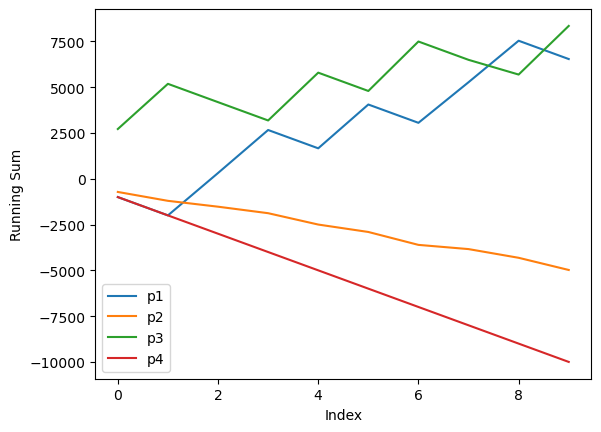

In [77]:

def plot_running_sums(data):
  """Plots the running sums of a dictionary of arrays.

  Args:
    data: A dictionary where the keys are labels and the values are arrays of numbers.
  """

  for label, values in data.items():
    running_sum = np.cumsum(values)
    plt.plot(running_sum, label=label)

  plt.xlabel("Index")
  plt.ylabel("Running Sum")
  plt.legend()
  plt.show()

plot_running_sums(results_dict)

In [ ]:
from pypokerengine.players import BasePokerPlayer

class DummyPlayer(BasePokerPlayer):
    def __init__(self):
        super().__init__()
        self.initial_game_info = None
        #print('Init: ', self.name)

    def declare_action(self, valid_actions, hole_card, round_state):
        print("valid_actions", valid_actions)
        print('round state', round_state)
        action = valid_actions[0]
        return action['action'], action['amount']

    def receive_game_start_message(self, game_info):
        print('receive_game_start_message', game_info)
        self.initial_game_info = game_info.copy()
        
    def receive_round_start_message(self, round_count, hole_card, seats):
        print('receive_round_start_message')
        pass

    def receive_street_start_message(self, street, round_state):
        print('receive_street_start_message')
        pass
        
    def receive_game_update_message(self, action, round_state):
        print('receive_game_update_message')
        pass

    def receive_round_result_message(self, winners, hand_info, round_state):
        print('receive_round_result_message')
        pass

config = setup_config(max_round=1, initial_stack=initial_stack, small_blind_amount=5)
config.register_player(name="p1", algorithm=DummyPlayer())
config.register_player(name="p2", algorithm=FishPlayer())
config.register_player(name="p3", algorithm=HonestPlayer())
game_result = start_poker(config, verbose=0)

In [ ]:
def exp_val(pot, bet, p_win):
    return p_win * (pot - bet) + (1-p_win) * (- bet)

samples = 100
pots = np.linspace(1, 100, samples)
bets = np.linspace(1, 100, samples)
p_wins = np.linspace(0, 1, samples)

In [ ]:
exp_vals = np.zeros((samples,samples,samples))

for i,pot in enumerate(pots):
    for j,bet in enumerate(bets):
        for k,p_win in enumerate(p_wins):
                   exp_vals[i,j,k] = exp_val(pot, bet, p_win)
            

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Generate data for plotting
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
x, y = np.meshgrid(x, y)
z = np.sin(np.sqrt(x**2 + y**2))

# Create the 3D surface plot
ax.plot_surface(x, y, z, cmap='viridis')

# Labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Show the plot
plt.show()
